# Setup <a id="setup"></a>
_import relevant packages_ \
_check for `.csv` files presence in filesystem_ \
_function to reduce memory useage by downcasting data types where appropriate_

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns # plotting
import pickle # saving models to a file
import time # training timer
from IPython.display import display
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler # normalize / scale data
from sklearn.decomposition import PCA # for LinearSVC only
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split # GridSearchCV for hyperparam config tuning
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
# classifcation_report contains precision, recall and F1-score
import gc # garbage collector (reduce memory use)
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
# print(f"Pandas version: {pd.__version__}")
# print(f"NumPy version: {np.__version__}")

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype        
        
        # handle object (string) types -> categorical
        if col_type == object:
            df[col] = df[col].astype('category')
        # handle numeric types
        else:
            c_min = df[col].min()
            c_max = df[col].max()
            
            # integer downcasting
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            
            # skip float16 to ensure SVM/Tree precision stability
            else:                
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

# Data Loading <a id="data-loading"></a>
_reduce memory memory useage before merge of transaction and identity data_ \
_explore data type before and after_ \
_show sample data_

In [ ]:
folder_path = '../input/ieee-fraud-detection/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
submission_file = pd.read_csv(f'{folder_path}sample_submission.csv')

print("--- train identity set data types ---")
display(train_identity.dtypes.value_counts())
print("--- train transaction set data types ---")
display(train_transaction.dtypes.value_counts())

print("\n--- test identity set data types ---")
display(test_identity.dtypes.value_counts())
print("--- test transaction set data types ---")
display(test_transaction.dtypes.value_counts())

# combine transaction and identity files in test and train sets after reducing memory useage
print("\nreducing memory for train_transaction...")
train_transaction = reduce_mem_usage(train_transaction)
print("\nreducing memory for train_identity...")
train_identity = reduce_mem_usage(train_identity)
print("\nreducing memory for test_transaction...")
test_transaction = reduce_mem_usage(test_transaction)
print("\nreducing memory for test_identity...")
test_identity = reduce_mem_usage(test_identity)

print("\nmerging data...")
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
print(f'train merged shape: {train.shape}')
print(f'test merged shape: {test.shape}')

del train_transaction, train_identity, test_transaction, test_identity
gc.collect();

# Data Exploration (EDA) <a id="eda"></a>
_inspect types, missing values_\
_statistical summaries and visualizations on raw (merged) data_

In [ ]:
# display("--- train_transaction.head() ---", train_transaction.head())
# display("--- train_identity.head() ---", train_identity.head())
display("--- train.head() ---", train.head(5))
display("--- test.head() ---", test.head(5))
# display("--- submission_file.head() ---", submission_file.head())

# train.to_csv("train.csv", index=False)
# test.to_csv("test.csv", index=False)

print(f'train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

print("\n--- train set data types after merge ---")
display(train.dtypes.astype(str).value_counts())

print("\n--- test set data types after merge ---")
display(test.dtypes.astype(str).value_counts())

In [ ]:
# threshold to drop columns
threshold = 0.60
top_columns = 25

print(f'There are {train.isnull().any().sum()} columns in train dataset with missing values.')
print(f'There are {test.isnull().any().sum()} columns in test dataset with missing values.')
print()

train_missing_percent = (train.isnull().sum() / len(train)).sort_values(ascending=False)
test_missing_percent = (test.isnull().sum() / len(test)).sort_values(ascending=False)

# display(f"train missing values top {top_columns} columns ", train_missing_percent.head(top_columns))
# display(f"test missing values top {top_columns} columns ", test_missing_percent.head(top_columns))

train_drop_count = (train_missing_percent > threshold).sum()
test_drop_count = (test_missing_percent > threshold).sum()

print(f'There are {train_drop_count} columns in train with > {threshold*100}% missing values.')
print(f'There are {test_drop_count} columns in test with > {threshold*100}% missing values.')
print()

one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test
print(f'There are {len(one_value_cols)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

# inspection of data types
num_cols_train = train.select_dtypes(include=[np.number]).columns
num_cols_test = test.select_dtypes(include=[np.number]).columns

cat_cols_train = train.select_dtypes(include=['object', 'category']).columns
cat_cols_test = test.select_dtypes(include=['object', 'category']).columns

print(f"\nnumerical columns in train: {len(num_cols_train)}")
print(f"categorical columns in train: {len(cat_cols_train)}")
print("-" * 30)
print(f"numerical columns in test: {len(num_cols_test)}")
print(f"categorical columns in test: {len(cat_cols_test)}")

print("\nsample of categorical data")
display("--- train ---", train[cat_cols_train].head())
display("--- test ---", test[cat_cols_test].head())

print("\nsample of numerical data")
display("--- train ---", train[num_cols_train].head())
display("--- test ---", test[num_cols_test].head())

In [ ]:
# plots for counts and percentages
fraud_counts = train['isFraud'].value_counts()
total_samples = len(train)
fraud_percentage = (fraud_counts[1] / total_samples) * 100
legit_percentage = (fraud_counts[0] / total_samples) * 100

print(f"Total Transactions: {total_samples}")
print(f"Legit (0): {fraud_counts[0]} ({legit_percentage:.2f}%)")
print(f"Fraud (1): {fraud_counts[1]} ({fraud_percentage:.2f}%)")

labels = ['Legit (0)', 'Fraud (1)']
sizes = [fraud_counts[0], fraud_counts[1]]
colors = ['#1f77b4', '#d62728'] 

plt.figure(figsize=(8, 6))
plt.pie(sizes, 
        labels=labels, 
        colors=colors, 
        autopct='%1.2f%%', # percentage labels
        startangle=140,    # rotate the start
        textprops={'fontsize': 12, 'fontweight': 'bold'})

plt.title('Distribution of Target Variable (isFraud)', fontsize=14)
plt.axis('equal')
plt.savefig('dist_pie.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# additional plots (raw data analysis)
sns.set_style("whitegrid")
# transaction amount distribution
plt.figure(figsize=(8, 6))
sns.histplot(train['TransactionAmt'], bins=50, color='blue', kde=True)
plt.title('Original Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('distamt_original.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
# log transform to see the "hidden" normal distribution
sns.histplot(np.log1p(train['TransactionAmt']), bins=50, color='green', kde=True)
plt.title('Log-Transformed Transaction Amount')
plt.xlabel('Log(Amount)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('distamt_log.png', dpi=300, bbox_inches='tight')
plt.show()

print("the log-transformation reveals a more normal-like distribution, suggesting we should likely log-transform this feature during preprocessing.")

# Data Preprocessing & Cleaning <a id="preprocessing"></a>
_ensure column names are equal_ \
_separate `isFraud` from training set_ \
_removal, imputation and label encoding_

In [ ]:
# fix column names in test set to match train set
test.columns = [col.replace('-', '_') for col in test.columns]

# columns present in train but missing in test (should only show isFraud after fix in preceding line)
missing_in_test = set(train.columns) - set(test.columns)
print(f"\ncolumns in train but not in test: {missing_in_test}")

In [ ]:
# separate target (test and train need to have the same amount of features)
if 'isFraud' in train.columns:
    y = train['isFraud'] # target
    X = train.drop(columns=['isFraud']) # data (without isFraud column)

# align test set
X_test = test.copy()

## Removal <a id="removal"></a>
_remove columns with more empty cells than the threshold_

In [ ]:
# recalculate missing percent on the feature set X
train_missing_percent = (X.isnull().sum() / len(X)).sort_values(ascending=False)

# columns to drop
cols_to_drop = train_missing_percent[train_missing_percent > threshold].index

# drop columns from both train (X) and test (X_test)
X = X.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')

print(f"dropped {len(cols_to_drop)} columns from X and X_test.")
print(f"X shape: {X.shape}")
print(f"X_test shape: {X_test.shape}")

print("\n--- train set data types after removal ---")
display(X.dtypes.astype(str).value_counts())

print("--- test set data types after removal ---")
display(X_test.dtypes.astype(str).value_counts())
print()
display("--- X.head() ---", X.head(5))
display("--- X_test.head() ---", X_test.head(5))

In [ ]:
# remove non-predictive columns (TransactionID, TransactionDT)
# save TransactionID before drop
test_ids = X_test['TransactionID'].copy()

cols_to_remove = ['TransactionID', 'TransactionDT']

for col in cols_to_remove:
    if col in X.columns:
        X = X.drop(columns=[col])
        X_test = X_test.drop(columns=[col])
        print(f"Dropped {col}.")
    else:
        print(f"{col} was already removed.")

display("--- X.head() ---", X.head(5))
display("--- X_test.head() ---", X_test.head(5))

## Imputation <a id="removal"></a>
_use `SimpleImputer` on numerical and categorical features_

In [ ]:
# select columns based on the (optimized) data types (after reducing memory useage)
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

print(f"imputing {len(num_cols)} numerical and {len(cat_cols)} categorical columns...")

# impute numerical with Median
num_imputer = SimpleImputer(strategy='median')
X[num_cols] = num_imputer.fit_transform(X[num_cols]).astype(np.float32) # calculate statistics, then transform
X_test[num_cols] = num_imputer.transform(X_test[num_cols]).astype(np.float32) # transform using stats from num_imputer above (after fit_transform on X)
# print(num_imputer.statistics_)
# print(num_imputer.n_features_in_)
# print(num_imputer.feature_names_in_)

# impute categorical with most_frequent (votes) mode
cat_imputer = SimpleImputer(strategy='most_frequent')
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols].astype(str))
X_test[cat_cols] = cat_imputer.transform(X_test[cat_cols].astype(str))
# print(cat_imputer.statistics_)
# print(cat_imputer.n_features_in_)
# print(cat_imputer.feature_names_in_)

print("Imputation Complete.")

remaining_nulls_train = X.isnull().sum().sum()
remaining_nulls_test = X_test.isnull().sum().sum()
print(f"remaining nulls in Train: {remaining_nulls_train}")
print(f"remaining nulls in Test: {remaining_nulls_test}")

## Label Encoding <a id="label-encoding"></a>
_use `LabelEncoder` to convert categorical features into numeric_

In [ ]:
print(f"label Encoding {len(cat_cols)} categorical features/columns: {list(cat_cols)}")

for col in cat_cols:
    le = LabelEncoder()
    
    # fit to train data (learn the vocabulary / cell data)
    le.fit(X[col].astype(str))
    X[col] = le.transform(X[col].astype(str))
    
    # dictionary mapping from the learned encoder
    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    
    # apply mapping to test, filling unknowns with -1
    X_test[col] = X_test[col].astype(str).map(le_dict).fillna(-1).astype(int)

print("label encoding complete. all features are now numeric.\n")

display("--- encoded train data ---", X.head(5))
display("--- encoded test data ---", X_test.head(5))

## Scale/Normalize Data <a id="scale"></a>

In [ ]:
# recommended to scale / normalize data for SVM
# still useful for Decistion Tree and XGBoost
scaler = StandardScaler()

# fit on train, transform both train and test
# all columns have Mean=0 and Variance=1
print("scaling features...")
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# convert back to DataFrame (Scaler returns a numpy array)
X = pd.DataFrame(X_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("scaling complete. data is ready for SVM.")

print("\nfeature means after scaling (should be ~0):")
print(X.mean().head(20))

# Models <a id="models"></a>
_train vs. validation set used for `internal` perfomance reporting_ \
_train vs. test set used for `kaggle competition` submission & ranking_ \
_area-under-the-curve (AUC) calculations are at the bottom_ \
_kaggle submissions are generated after AUC_

In [ ]:
print("splitting full dataset into train and validation...")
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, # set test size %
    random_state=42, # reproducibility
    stratify=y # to have equal proportion of fraud / legit samples in validation set as in train set
)
print(f"X_train shape: {X_train.shape}\nX_val shape: {X_val.shape}\ny_train shape: {y_train.shape}\ny_val shape: {y_val.shape}")

## SVM <a id="svm"></a>
_euclidean distance_ \
_classifier that seeks to maximize margin (decision boundary between classes)_ \
_Due to dataset size (590k+ rows), we use `LinearSVC`_ \
_applied feature reduction with PCA to improve training speed_ \
_Hyperparameters tuned: C (regularization), penalty (L1 vs. L2) and tolerance_ \
_Validation splits used to evaluate performance_ \
_Metrics: Confusion Matrix, Precision, Recall, F1-Score_

**We utilized `LinearSVC` to train on the entire dataset. A standard `svm.SVC` with a non-linear kernel (`rbf`) was computationally infeasible for 590,000+ rows without aggressive down-sampling.**

In [ ]:
# apply PCA only for SVM to reduce computational workload (speed!)
pca = PCA(
    n_components=0.95, # enough features to "explain" % of data's variance (feature reduction)
    random_state=42 # reproducibility
)

print("applying PCA to training set...")
X_train_pca = pca.fit_transform(X_train)

print("applying PCA to validation/test sets...")
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"original shape: {X_train.shape}")
print(f"PCA Shape: {X_train_pca.shape} (features reduced!)")

In [ ]:
# combination of parameter tuning
param_grid = [
    # smaller `C` values increase regularization (wider margins) should improve convergence speed
    # loss: ???
    # dual = False, when n_samples > n_features, `auto` for the function to choose param automatically
    # tol: tolerance for stopping criteria
    # penalty: defaults to L2 - ???
    {'C': [0.1, 0.01, 0.001], 'loss': ['squared_hinge'], 'dual': [False], 'penalty': ['l2'], 'tol': [1e-4]},
    {'C': [0.1, 0.01, 0.001], 'loss': ['squared_hinge'], 'dual': [False], 'penalty': ['l1'], 'tol': [1e-3]},
]

lsvc_start = time.perf_counter()
print("Starting LinearSVC training on PCA data...")
# GridSearchCV to tune hyperparams; try every combination in param_grid
grid_lsvc = GridSearchCV(
    LinearSVC(
        random_state=42, # reproducibility
        max_iter=5000, # prevent infinite loops if model struggles to converge
        class_weight='balanced' # when data is unbalanced (we have more legit transactions than fraudulent ones)
    ), 
    param_grid, 
    cv=3, # cross-validation splitter; training iterations with params
    verbose=2, 
    n_jobs=-1 # use all available CPUs/threads (parallel processing)
)

# using PCA data for training!
grid_lsvc.fit(X_train_pca, y_train)
print("LinearSVC training complete!")
lsvc_end = time.perf_counter()
lsvc_elapsed_time = lsvc_end - lsvc_start
print(f"LinearSVC training took {lsvc_elapsed_time:.4f} seconds")

print("saving LinearSVC models object and PCA to a file...")
lin_svc_filename = "models_linear_svc.pkl" # saving all models from training
pca_filename = "processor_pca.pkl"
with open(lin_svc_filename, 'wb') as file:
    pickle.dump(grid_lsvc, file)
with open(pca_filename, 'wb') as file:
    pickle.dump(pca, file)

print(f"LinearSVC models object saved to '{lin_svc_filename}' and PCA to '{pca_filename}'")

In [ ]:
# load model and pca if already saved
lin_svc_filename = "models_linear_svc.pkl"
pca_filename = "processor_pca.pkl"
# grid_lsvc = None
# pca = None
try:
    with open(lin_svc_filename, "rb") as file:
        grid_lsvc = pickle.load(file)
    print(f"'{lin_svc_filename}' loaded successfully!")

    with open(pca_filename, "rb") as file:
        pca = pickle.load(file)
    print(f"'{pca_filename}' loaded successfully!")
    
except FileNotFoundError as e:
    print(f"Error: Missing file. {e}")
except Exception as e:
    print(f"Error loading files: {e}")

In [ ]:
# intermediate results (different hyperparams)
if grid_lsvc is not None and pca is not None:
    if hasattr(grid_lsvc, 'best_params_'):
        print(f"\nbest LinearSVC parameters: {grid_lsvc.best_params_}")
        results = pd.DataFrame(grid_lsvc.cv_results_)
        # comparison table
        display(results[['param_C', 'param_loss', 'param_penalty', 'mean_test_score', 'rank_test_score']].head(10))
    
        # final (train vs. validation) metrics
        best_lsvc = grid_lsvc.best_estimator_
    else:
        print("using loaded object as model")
        best_lsvc = grid_lsvc
    
    # final results (training set, y_train)
    print("\n" + "="*40)
    print("--- training set performance ---")
    print("="*40)
    print("transforming training data with PCA...")
    X_train_transformed = pca.transform(X_train)
    y_train_pred = best_lsvc.predict(X_train_transformed)    
    print(f"accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print("classification report")
    print(classification_report(y_train, y_train_pred))

    print("="*40)
    print("--- validation set performance ---")
    print("="*40)
    print("transform validation data with PCA...")
    X_val_transformed = pca.transform(X_val)    
    y_pred = best_lsvc.predict(X_val_transformed) # predict using transformed (PCA) data    
    print(f"accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print("classification report")
    print(classification_report(y_val, y_pred))

    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('LinearSVC Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('cmatrix_lsvc.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print(f"skipping evaluation because {grid_lsvc} or {pca} could not be loaded.")

## Decision Tree <a id="decision-tree"></a>
_rules-based_ \
_max_depth, min_samples_split, criterion etc. hyperparameters (report different results)_ \
_trains approx. 54 decision trees and selects the best one for metrics_ \
_validation splits to evaluate performance_ \
_training and test metrics: confusion matrix, precision, recall, F1-score and accuracy_

In [ ]:
dt_params = {
    'max_depth': [10, 20, None], # height of tree; None means nodes are expanded until all leaves are pure
    'min_samples_split': [20, 100, 500], # minimum number of samples required to split an internal node
    'criterion': ['gini', 'entropy']  # gini: how mixed (impurity), entropy: reduction in chaos/surprise
}

dt_start = time.perf_counter()
print("starting Decision Tree training...")
# GridSearchCV to tune hyperparams; try every combination in grid_dt
grid_dt = GridSearchCV(
    DecisionTreeClassifier(
        random_state=42 # reproducibility
    ),
    dt_params, 
    cv=3, # cross-validation splitter; training iterations with params
    verbose=2, 
    n_jobs=-1 # use all available CPUs/threads (parallel processing)
)

# use full X_train dataset
grid_dt.fit(X_train, y_train)
print("Decision Tree training complete!")
dt_end = time.perf_counter()
dt_elapsed_time = dt_end - dt_start
print(f"Decision Tree training took {dt_elapsed_time:.4f} seconds")

print("saving Decision Tree models object...")
dt_filename = 'models_decision_tree.pkl'
with open(dt_filename, 'wb') as file:
    pickle.dump(grid_dt, file)
print(f"Decision Tree models object saved to '{dt_filename}'")

In [ ]:
# load model if already saved
dt_filename = 'models_decision_tree.pkl'
# grid_dt = None
try:
    with open(dt_filename, "rb") as file:
        grid_dt = pickle.load(file)
    print(f"{dt_filename} loaded successfully!")
    
except FileNotFoundError:
    print(f"Error: The file '{dt_filename}' was not found.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

In [ ]:
# intermediate results (different hyperparams)
if grid_dt is not None:
    print(f"\nbest Decision Tree parameters: {grid_dt.best_params_}")
    
    results_dt = pd.DataFrame(grid_dt.cv_results_)
    # comparison table
    display(results_dt[['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'rank_test_score']].head(10))
    
    best_dt = grid_dt.best_estimator_
    
    # final (train vs. validation) metrics
    print("\n" + "="*40)
    print("--- training set performance ---")
    print("="*40)
    print("predicting training data...")
    y_train_pred_dt = best_dt.predict(X_train)   
    print(f"accuracy: {accuracy_score(y_train, y_train_pred_dt):.4f}")
    print("classification report")
    print(classification_report(y_train, y_train_pred_dt))

    print("\n" + "="*40)
    print("--- validation set performance ---")
    print("="*40)
    print("predicting validation data...")
    y_val_pred_dt = best_dt.predict(X_val)
    print(f"accuracy: {accuracy_score(y_val, y_val_pred_dt):.4f}")
    print("classification report")
    print(classification_report(y_val, y_val_pred_dt))   

    cm_dt = confusion_matrix(y_val, y_val_pred_dt)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens')
    plt.title('Decision Tree Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('cmatrix_dt.png', dpi=300, bbox_inches='tight')
    plt.show()

    # feature importance
    importances = best_dt.feature_importances_
    feature_names = X_train.columns
    feature_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })

    feature_imp_df = feature_imp_df.sort_values(by='importance', ascending=False).head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_imp_df, palette='viridis')
    plt.title('Decision Tree: Top 10 Features')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature Name')
    plt.show()
else:    
    print(f"skipping evaluation because {grid_dt} could not be loaded.")

## XGBoost <a id="xgb"></a>
_extreme gradient boosting (ensemble method)_ \
_Builds trees sequentially, where each new tree corrects the errors of the previous one_ \
_Optimized for speed ('hist' tree method) and performance_ \
_Generally handles class imbalance and non-linear patterns better than single trees_ \
_has GPU support_

In [ ]:
xgb_start = time.perf_counter()
print("starting XGBoost training...")

xgb_classifier = xgb.XGBClassifier(
    n_estimators=500, # trees to build for boosting
    max_depth=9, # tree depth
    learning_rate=0.05, # "correction speed"; how much each tree contributes to the final prediction
    subsample=0.9, # % of rows used to train each tree
    colsample_bytree=0.9, # % of features/columns available to each tree
    random_state=42, # for reproducibility across training runs
    tree_method='hist', # fast histogram optimized method
    verbosity=2,
    n_jobs=-1 # use all available CPUs/threads (parallel processing)
)

xgb_classifier.fit(X_train, y_train)
print("XGBoost training complete!")
xgb_end = time.perf_counter()
xgb_elapsed_time = xgb_end - xgb_start
print(f"XGBoost training took {xgb_elapsed_time:.4f} seconds")

print("saving XGBoost model...")
xgb_filename = 'model_xgboost.pkl'
with open(xgb_filename, 'wb') as file:
    pickle.dump(xgb_classifier, file)
print(f"XGBoost model saved to '{xgb_filename}'")

In [ ]:
# load model if already saved
xgb_filename = 'model_xgboost.pkl'
# xgb_classifier = None
try:
    with open(xgb_filename, "rb") as file:
        xgb_classifier = pickle.load(file)
    print(f"{xgb_filename} loaded successfully!")
    
except FileNotFoundError:
    print(f"Error: The file '{xgb_filename}' was not found.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

In [ ]:
# results
if xgb_classifier is not None:
    print("="*40)
    print("--- training set performance ---")
    print("="*40)
    print("predicting training data...")
    y_train_pred_xgb = xgb_classifier.predict(X_train)
    print(f"accuracy: {accuracy_score(y_train, y_train_pred_xgb):.4f}")
    print("classification report")
    print(classification_report(y_train, y_train_pred_xgb))

    print("\n" + "="*40)
    print("--- validation set performance ---")
    print("="*40)
    y_val_pred_xgb = xgb_classifier.predict(X_val)
    print(f"accuracy: {accuracy_score(y_val, y_val_pred_xgb):.4f}")
    print("classification report")
    print(classification_report(y_val, y_val_pred_xgb))    

    cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges')
    plt.title('XGBoost Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('cmatrix_xgb.png', dpi=300, bbox_inches='tight')
    plt.show()

    # feature importance
    plt.figure(figsize=(10, 6))
    xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, color='orange')
    plt.title("Top 10 Features driving Fraud Detection")
    plt.show()
else:
    print(f"skipping evaluation because {xgb_classifier} could not be loaded.")

# Area-Under-The-Curve (AUC) <a id="auc-roc"></a>
While **Accuracy** measures the percentage of correct predictions, it can be misleading in imbalanced datasets. The **AUC-ROC (Area Under the Receiver Operating Characteristic Curve)** provides a more robust metric by evaluating the model's ability to **rank** transactions based on confidence.
- **ROC Curve** plots the trade-off between the **True Positive Rate (Recall)** and the **False Positive Rate** at various threshold settings.
- **AUC Score** ranges from 0.0 to 1.0:
    * **0.5:** No better than random guessing.
    * **1.0:** Perfect classification.
    * **> 0.8:** Generally considered good performance for fraud detection.

A high AUC score indicates that the model assigns higher probability scores to actual Fraud cases than to Legit cases, regardless of the specific classification threshold chosen.

In [ ]:
print("--- AUC-ROC SCORES ---")

# LinearSVC uses decision_function to get distance to the margin scores
y_scores_svm = best_lsvc.decision_function(X_val_pca) # using PCA data
auc_svm = roc_auc_score(y_val, y_scores_svm)
print(f"SVM AUC: {auc_svm:.4f}")

# Decision Tree uses predict_proba
# get probability of fraud (class 1)
y_probs_dt = best_dt.predict_proba(X_val)[:, 1] 
auc_dt = roc_auc_score(y_val, y_probs_dt)
print(f"Decision Tree AUC: {auc_dt:.4f}")

# XGBoost uses predict_proba
y_probs_xgb = xgb_classifier.predict_proba(X_val)[:, 1]
auc_xgb = roc_auc_score(y_val, y_probs_xgb)
print(f"XGBoost AUC: {auc_xgb:.4f}")

# plots
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_val, y_scores_svm)
plt.plot(fpr, tpr, label=f"SVM (AUC = {auc_svm:.2f})")

fpr, tpr, _ = roc_curve(y_val, y_probs_dt)
plt.plot(fpr, tpr, label=f"Decision Tree (AUC = {auc_dt:.2f})")

fpr, tpr, _ = roc_curve(y_val, y_probs_xgb)
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_xgb:.2f})")

# plot Diagonal (Random Guessing)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.50)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves Comparison")
plt.legend()
plt.savefig('auc.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print("--- fraud predictions on test dataset ---")

print("\nLinearSVC (using X_test_pca)...")
test_pred_svm_scores = best_lsvc.decision_function(X_test_pca)
test_pred_svm_hard = best_lsvc.predict(X_test_pca) 

# print(f"shape: {test_pred_svm_scores.shape}")
# print(f"first 10 Scores: {test_pred_svm_scores[:10]}")
print(f"predicted fraud rate: {test_pred_svm_hard.mean():.4%}")

print("\nDecision Tree (using X_test)...")
test_pred_dt_prob = best_dt.predict_proba(X_test)[:, 1]
test_pred_dt_hard = best_dt.predict(X_test)

# print(f"shape: {test_pred_dt_prob.shape}")
# print(f"first 10 probabilities: {test_pred_dt_prob[:10]}")
print(f"predicted fraud rate: {test_pred_dt_hard.mean():.4%}")

print("\nXGBoost (using X_test)...")
test_pred_xgb_prob = xgb_classifier.predict_proba(X_test)[:, 1]
test_pred_xgb_hard = xgb_classifier.predict(X_test)

# print(f"shape: {test_pred_xgb_prob.shape}")
# print(f"first 10 probabilities: {test_pred_xgb_prob[:10]}")
print(f"predicted fraud rate: {test_pred_xgb_hard.mean():.4%}")

# Submission to kaggle <a id="kaggle-submit"></a>
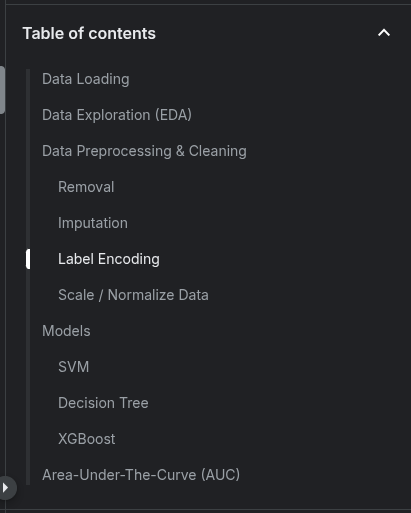

In [ ]:
print("\ngenerating kaggle submissions...")

# LinearSVC uses decision_function() to get continuous "confidence scores" (distance to margin)
print("generating LinearSVC submission (Scores)...")
pred_svm_scores = best_lsvc.decision_function(X_test_pca) # using PCA data

sub_lsvc = pd.DataFrame({
    'TransactionID': test_ids.astype(int), # TransactionID was saved before dropping (preprocessing section)
    'isFraud': pred_svm_scores
})
filename_svm = 'submission_lsvc_auc.csv'
sub_lsvc.to_csv(filename_svm, index=False)
print(f"saved '{filename_svm}'")

# Decision Tree uses predict_proba() to get the probability of Class 1 (Fraud)
# get probability [:, 1]
print("Generating Decision Tree submission (Probabilities)...")
pred_dt_probs = best_dt.predict_proba(X_test)[:, 1]

sub_dt = pd.DataFrame({
    'TransactionID': test_ids.astype(int),
    'isFraud': pred_dt_probs
})
filename_dt = 'submission_decision_tree_auc.csv'
sub_dt.to_csv(filename_dt, index=False)
print(f"saved '{filename_dt}'")

# XGBoost uses predict_proba() for high-precision probabilities
print("Generating XGBoost submission (Probabilities)...")
pred_xgb_probs = xgb_classifier.predict_proba(X_test)[:, 1]

sub_xgb = pd.DataFrame({
    'TransactionID': test_ids.astype(int),
    'isFraud': pred_xgb_probs
})
filename_xgb = 'submission_xgboost_auc.csv'
sub_xgb.to_csv(filename_xgb, index=False)
print(f"saved '{filename_xgb}'")

# previews
print("\npreview of LinearSVC submission")
print(pd.read_csv(filename_svm).head())

print("\npreview of Decision Tree submission")
print(pd.read_csv(filename_dt).head())

print("\npreview of XGBoost submission")
print(pd.read_csv(filename_xgb).head())